In [30]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')
import os
path = '../../../DEVELOPMENT/Fraud Detection/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [31]:
train_sample = pd.read_csv(path+'train_sample.csv', dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
test = pd.read_csv(path+'test.csv', dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

In [32]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

167

In [33]:
def prep_data(d):
    d['hour'] = pd.to_datetime(d.click_time).dt.hour.astype('uint8')
    d['day'] = pd.to_datetime(d.click_time).dt.day.astype('uint8')
    d['wday']  = pd.to_datetime(d.click_time).dt.dayofweek.astype('uint8')
    
    print('grouping by ip-day-hour combination')
    gp = d[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
    d = d.merge(gp, on=['ip','day','hour'], how='left')
    del gp; gc.collect()
    
    print('group by ip-app combination')
    gp = d[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
    d = d.merge(gp, on=['ip','app'], how='left')
    del gp; gc.collect()
    
    print('group by ip-app-os combination')
    gp = d[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
    d = d.merge(gp, on=['ip','app', 'os'], how='left')
    del gp; gc.collect()
    
    print("vars and data type")
    d['qty'] = d['qty'].astype('uint16')
    d['ip_app_count'] = d['ip_app_count'].astype('uint16')
    d['ip_app_os_count'] = d['ip_app_os_count'].astype('uint16')
    
    print("label encoding....")
    from sklearn.preprocessing import LabelEncoder
    d[['app','device','os', 'channel', 'hour', 'day', 'wday']].apply(LabelEncoder().fit_transform)
    print('dropping')
    d.drop(['click_time', 'ip'], 1, inplace=True)
    
    return d

In [34]:
train_df = prep_data(train_sample)
test_df = prep_data(test)

grouping by ip-day-hour combination
group by ip-app combination
group by ip-app-os combination
vars and data type
label encoding....
dropping
grouping by ip-day-hour combination
group by ip-app combination
group by ip-app-os combination
vars and data type
label encoding....
dropping


In [29]:
train_df.head()

,app,device,os,channel,is_attributed,hour,day,wday,qty,ip_app_count,ip_app_os_count
0,12,1,13,497,0,9,7,1,1,3,2
1,25,1,17,259,0,13,7,1,4,4,1
2,12,1,19,212,0,18,7,1,1,1,1
3,13,1,13,477,0,4,7,1,1,1,1
4,12,1,1,178,0,9,9,3,1,2,1


In [8]:
RANDOM_SEED = 1
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

X_train, X_test = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED)

y_train = X_train['is_attributed']
X_train = X_train.drop(['is_attributed'], axis=1)
y_test = X_test['is_attributed']
X_test = X_test.drop(['is_attributed'], axis=1)

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=9, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [10]:
predictions = rf.predict_proba(X_test)
predictions

array([[  9.99751337e-01,   2.48663447e-04],
       [  9.99923056e-01,   7.69441874e-05],
       [  9.95268253e-01,   4.73174733e-03],
       ..., 
       [  9.99148936e-01,   8.51063830e-04],
       [  9.99298368e-01,   7.01631787e-04],
       [  1.00000000e+00,   0.00000000e+00]])

In [11]:
def convert_preds(raw_preds):
    preds = []
    for p in raw_preds:
        preds.append(1 - p[0])
    return preds

In [12]:
val_preds = convert_preds(predictions)

In [13]:
max(val_preds)

0.63089353141984716

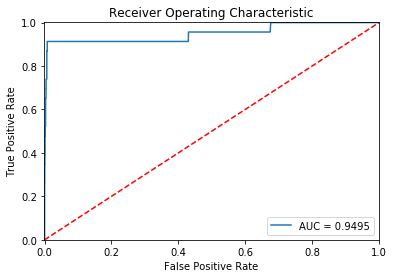

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y_test, val_preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [17]:
predictions = rf.predict_proba(test_df)

In [18]:
sub_preds = convert_preds(predictions)

In [20]:
len(predictions)

18790469

In [21]:
len(sub_preds)

18790469

In [22]:
sub['is_attributed'] = sub_preds
sub.head()

,click_id,is_attributed
0,0,0.025000
1,1,0.000000
2,2,0.001796
3,3,0.026796
4,4,0.000000


In [23]:
sub.to_csv('RF3.csv', float_format='%.8f', index=False)